In [1]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

In [2]:
using ConfParser
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)
md_fname = "h3_sto3g_072225%1013.hdf5"
#md_fname = "h2o_sto3g_032024%0918.hdf5"

chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname, uhf=true)

conf = ConfParse("../configs/pyscf_configs/h3_stretch.ini")
#conf = ConfParse("../configs/pyscf_configs/h2o_stretch_sto3g.ini")

parse_conf!(conf)
bond_lengths = parse.(Float64, retrieve(conf, "GEOMETRIES", "xyz_files")); # H6 bond sep = sqrt(2)*radial distance

In [3]:
#TEST TO ENSURE CORRECT CHEMICAL DATA LOADED
# Choose a bond length:
n_x = 12
println("r = $(bond_lengths[n_x]) Angstrom")
chemical_data = chemical_data_list[n_x]
PrintChemData(chemical_data)

r = 1.05 Angstrom
Molecule name: h3
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/h3_stretch/1.05.xyz
XHF energy: -1.1779971535956597
FCI energy: -1.2163202345707158


In [4]:
#USE THE FCI DATA TO CONSTRUCT AN "OPTIMAL" ORDERING BASED ON MUTUAL INFORMATION
# IF RUNNING UHF OR DIDNT DO FCI USE THE NEXT CELL


# Visualize the mutual information and calculate a "quasi-optimal" ordering:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", chemical_data.N_spt), cutoff=1e-16, maxdim=2^16);

print(fci_array)

S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
#print(Ipq)
OrbitalGraphPlot(Ipq, multiplier=2e1)

gp = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=0.8
)

opt_ord = InfDistAnnealing(
    Ipq, 
    1,                                                           
    gp,
    verbose=true
)[1]

#opt_ord = [1,2,3,4,5,6]

println("Quasi-optimal ordering: $(opt_ord)")
OrbitalGraphPlot(GraphMat(opt_ord, directed=false), multiplier=2.0)

BoundsError: BoundsError: attempt to access 2×2 Matrix{Float64} at index [3, 1]

In [4]:
#TO CONSTRUCT THE MPS FOR A UHF BASIS USING YOUR CHEMICAL INTUITION (no pressure)

# obtain occupation information:
num_mps_sites = chemical_data_list[1].N_spt

N = num_mps_sites  # total spin orbitals
#initialize the mps
sites = siteinds("Electron", N; conserve_qns=true)
function uhf_to_mps(alpha_occ, beta_occ, sites,ordering="HOMO_matching")
  state = Vector{String}(undef, length(sites))
  state[1]="Emp"
  state[2]="Emp"
  state[3]="Up"
  state[4]="Dn"
  state[5]="Emp"
  state[6]="Emp"
  """
  quarter = div(length(sites), 4)
  half = div(length(sites), 2)
    # Set the MPS based on some predefined order. Optimal ordering tbd
  if ordering == "HOMO_matching"
     for i in 1:length(sites)
      if i <= quarter
        println("emp")
        state[i] = "Emp"
      elseif i <= 2*quarter
        println("up")
        state[i] = "Up"
      elseif i <= 3*quarter
        println("dn")
        state[i] = "Dn"
      else
        println("emp")
        state[i] = "Emp"
      end
     end
  elseif ordering == "alternate"
     for i in 1:length(sites)
      if i <= half
        if i % 2 == 1
          state[i] = "Up"
          println("up")
        else
          state[i] = "Dn"
          println("dn")
        end
      else
        println("emp")
        state[i] = "Emp"
      end
     end
  end"""
    return productMPS(sites, state)
end
  
#HOMO_matching => HOMOs in middle
#alternate => low to high energy alternating alpha/beta
ordering_scheme = "HOMO_matching"
mps = uhf_to_mps(chemical_data_list[1].alpha_occ_string, chemical_data_list[1].beta_occ_string, sites, ordering_scheme)


MPS
[1] ((dim=4|id=238|"Electron,Site,n=1") <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1, (dim=1|id=301|"Link,l=1") <In>
 1: QN(("Nf",0,-1),("Sz",0)) => 1)
[2] ((dim=1|id=301|"Link,l=1") <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1, (dim=4|id=771|"Electron,Site,n=2") <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1, (dim=1|id=116|"Link,l=2") <In>
 1: QN(("Nf",0,-1),("Sz",0)) => 1)
[3] ((dim=1|id=116|"Link,l=2") <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1, (dim=4|id=482|"Electron,Site,n=3") <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1, (dim=1|id=958|"Link,l=3") <In>
 1: QN(("Nf",1,-1),("Sz",1)) => 1)
[4] ((dim=1|id=958|"Link,l=3") <Out>
 1: QN(("Nf",1,-1),("Sz",1)) => 1, (dim=4|id=476|"Electron,Site,n=4") <Out>

In [ ]:
#TO CONSTRUCT THE MPS FOR A UHF BASIS USING YOUR CHEMICAL INTUITION (no pressure)

# obtain occupation information:
num_mps_sites = chemical_data_list[1].N_spt

N = num_mps_sites  # total spin orbitals
#initialize the mps
sites = siteinds("Fermion", N; conserve_qns=true)
function uhf_to_mps(alpha_occ, beta_occ, sites,ordering="HOMO_matching")
  state = Vector{String}(undef, length(sites))
  quarter = div(length(sites), 4)
  half = div(length(sites), 2)
    # Set the MPS based on some predefined order. Optimal ordering tbd
  if ordering == "HOMO_matching"
     for i in 1:length(sites)
      if i <= quarter
        println("emp")
        state[i] = "Emp"
      elseif i <= 2*quarter
        println("up")
        state[i] = "Up"
      elseif i <= 3*quarter
        println("dn")
        state[i] = "Dn"
      else
        println("emp")
        state[i] = "Emp"
      end
     end
  elseif ordering == "alternate"
     for i in 1:length(sites)
      if i <= half
        if i % 2 == 1
          state[i] = "Up"
          println("up")
        else
          state[i] = "Dn"
          println("dn")
        end
      else
        println("emp")
        state[i] = "Emp"
      end
     end
  end
    return productMPS(sites, state)
end
  
#HOMO_matching => HOMOs in middle
#alternate => low to high energy alternating alpha/beta
ordering_scheme = "HOMO_matching"
mps = uhf_to_mps(chemical_data_list[1].alpha_occ_string, chemical_data_list[1].beta_occ_string, sites, ordering_scheme)


In [5]:
# The optimization parameters:
op1 = OptimParameters(
    maxiter=1, 
    numloop=1,  
    thresh="projection",
    eps=1e-12,
    sd_thresh="projection", 
    sd_eps=1.0e-12,
    delta=[1e-6,1e-7], # QPU noise
    noise=[0.3], # DMRG "noise" term
    sd_method="triple_geneig",
    sd_dtol=5e-3,
    sd_etol=1e-3
)

chi = 4
M_max = 4

# Messing around with noise parameters, the energy tolerance threshold, \\
# ...and the sweep number can boost performance in the parameter count

#delta_list = [[0.0,0.0] for M=2:M_max] # Noiseless
#delta_list = [[1e-7,1e-8], [1e-9,1e-10], [1e-11,1e-12]] # Light QPU noise
delta_list = [[1e-4,1e-5] for M=2:M_max] # Heavy QPU noise
etol_list = [2e-3,1e-3,5e-4,2e-4,1e-4,5e-5]
#numsweeps = [4, 12] # 4 single-MPS optim sweeps and 2*12=24 multi-MPS optim sweeps
numsweeps = [4, 6] # 4 single-MPS optim sweeps and 2*6=12 multi-MPS optim sweeps

2-element Vector{Int64}:
 4
 6

In [7]:
println(chemical_data.N_spt)

6


In [6]:
# Random initial ordering sometimes works even better than the Ipq-heuristic ordering:
#opt_ord = randperm(chemical_data.N_spt)

tnqe0 = GenSubspace(
    chemical_data,
    constructed_mps=mps, # Use the UHF MPS as the initial state 
    M=1, 
    mps_maxdim=chi, 
    ham_tol=1e-14,
    perm_tol=1e-14,
    thresh="projection", 
    init_ord = [3,2,1,4,5,6],
    eps=1e-12, 
    sweep_num=20, 
    sweep_noise=(1e-3,1e-3,1e-3),
    dmrg_init=true,
    ovlp_opt=true,
    ovlp_weight=2.0,
    uhf=true,
    verbose=true,
    sites=sites
);


Generating Hamiltonian MPO:
Dict(2 => 2, 3 => 1, 1 => 3)
Dict(2 => 5, 3 => 6, 1 => 4)
(3, 3, 3, 3)
Done making MPO hamiltonian!


Generating Hamiltonian sparse matrix:
Matrix Reduced
Sparse matrix constructed
Done!



"Number of non-zero terms in the OpSum: 174"

MPO
[1] ((dim=7|id=979|"Link,l=1") <Out>
 1: QN() => 1
 2: QN(("Nf",0,-1),("Sz",0)) => 1
 3: QN(("Nf",2,-1),("Sz",2)) => 1
 4: QN(("Nf",-1,-1),("Sz",-1)) => 1
 5: QN(("Nf",-2,-1),("Sz",-2)) => 1
 6: QN(("Nf",1,-1),("Sz",1)) => 1
 7: QN(("Nf",0,-1),("Sz",0)) => 1, (dim=4|id=238|"Electron,Site,n=1")' <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1, (dim=4|id=238|"Electron,Site,n=1") <In>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1)
[2] ((dim=7|id=979|"Link,l=1") <In>
 1: QN() => 1
 2: QN(("Nf",0,-1),("Sz",0)) => 1
 3: QN(("Nf",2,-1),("Sz",2)) => 1
 4: QN(("Nf",-1,-1),("Sz",-1)) => 1
 5: QN(("Nf",-2,-1),("Sz",-2)) => 1
 6: QN(("Nf",1,-1),("Sz",1)) => 1
 7: QN(("Nf",0,-1),("Sz",0)) => 1, (dim=12|id=395|"Link,l=2") <Out>
 1: QN() => 1
 2: QN(("Nf",0,-1),("Sz",0)) => 4
 3: QN(("Nf",2,-1),("Sz",2)) => 1
 4: 

4096×4096 SparseMatrixCSC{Float64, Int64} with 151 stored entries:
⎡⠱⣦⠀⠀⠀⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠤⠀⠀⠀⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠁⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠉⠂⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

BoundsError: BoundsError: attempt to access 6-element Vector{Int64} at index [7]

In [10]:
#rotypes = ["none","none","none"]
#rotypes = ["fswap","fswap","fswap"]
rotypes = ["givens","givens","givens"]


tnqe3_evec_full = []
tnqe3_evec = []
tnqe3_pvec = []
tnqe3_cvec = []

tnqe3 = deepcopy(tnqe0)

push!(tnqe3_evec, tnqe3.E[1])
push!(tnqe3_evec_full, tnqe3.E[1])
push!(tnqe3_pvec, CountNonZeros(tnqe3.phi_list))

tot_calls = 0

for k=1:M_max-1
    
    op1.delta = [delta_list[k][1],delta_list[k][2]]
    op1.sd_etol = etol_list[k]
    
    AddStates!(
        tnqe3;
        M_new=1,
        G_init="last",
        dmrg_init=(k==1),
        ovlp_opt=true,
        ovlp_weight=2.0,
        verbose=false
    )
    
    # Permute so new states are at the front:
    perm = circshift(collect(1:tnqe3.mparams.M), 1)
    
    ShuffleStates!(tnqe3, perm=perm, no_rev=true)
    
    println("\n$(tnqe3.mparams.M) states:\n")
    
    for l=1:numsweeps[1]
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=vcat([2], [0 for i=2:tnqe3.mparams.M]),
            rotype=rotypes[1],
            jperm=vcat([1], shuffle(2:tnqe3.mparams.M)),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        
    end
    
    for l=1:numsweeps[2]
        
        perm = randperm(tnqe3.mparams.M)
        ShuffleStates!(tnqe3, perm=perm, no_rev=true)
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=[2 for i=1:tnqe3.mparams.M],
            rotype=rotypes[2],
            jperm=collect(1:tnqe3.mparams.M),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        ShuffleStates!(tnqe3, perm=invperm(perm), no_rev=true)
        
        perm = randperm(tnqe3.mparams.M)
        ShuffleStates!(tnqe3, perm=perm, no_rev=true)
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=[2 for i=1:tnqe3.mparams.M],
            rotype=rotypes[3],
            jperm=collect(1:tnqe3.mparams.M),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        ShuffleStates!(tnqe3, perm=invperm(perm), no_rev=true)
        
    end
    
    push!(tnqe3_evec, tnqe3.E[1])
    push!(tnqe3_pvec, CountNonZeros(tnqe3.phi_list))
    push!(tnqe3_cvec, tot_calls)
    println("\nTotal QPU calls = $(tot_calls)\n")
    
end

"""
nomps_evec = deepcopy(tnqe3_evec)
nomps_evec_full = deepcopy(tnqe3_evec_full)
nomps_pvec = deepcopy(tnqe3_pvec)

fswap_evec = deepcopy(tnqe3_evec)
fswap_evec_full = deepcopy(tnqe3_evec_full)
fswap_pvec = deepcopy(tnqe3_pvec)

"""

givens_evec3 = deepcopy(tnqe3_evec)
givens_evec3_full = deepcopy(tnqe3_evec_full)
givens_pvec3 = deepcopy(tnqe3_pvec)
givens_cvec3 = deepcopy(tnqe3_cvec)


[-2.6621641810272645 -2.6653686672720136e-7; -2.6653686672720136e-7 -2.6461147179688256]
[1.0000000000000004 1.0012267826743376e-7; 1.0012267826743376e-7 1.0]
[-2.6461147179688256 -2.665368667242726e-7; -2.665368667242726e-7 -2.6621641810272645]
[1.0 1.0012267826743376e-7; 1.0012267826743376e-7 1.0000000000000004]

2 states:

[-2.6461147179688256 -2.665368667242726e-7; -2.665368667242726e-7 -2.6621641810272645]
[1.0 1.0012267826743376e-7; 1.0012267826743376e-7 1.0000000000000004]
[-1.948289628005387 -9.507513421969622e-5 0.00011921698667072482 0.2940193698252814 9.432129972765931e-5 -0.04601578887594953 0.35916950971692746; 0.00012687235404305875 -1.583413009373131 0.3791133429887588 7.16999232070067e-5 0.24121616340643534 -4.7365314928860616e-5 -8.660458680013595e-5; 2.743188442760972e-5 0.37924068239703473 -2.3411045134536543 2.6049171211523427e-6 0.2545035827143681 -9.767558814331044e-6 2.3982748012712085e-6; 0.29443088725184363 -0.00021674208471482602 0.00016543536323990342 -1.9803

Excessive output truncated after 524299 bytes.

 1.1187708241419274 2.320608289871257; 4.324943213072288e-5 -1.6774068460341605e-5 5.067488316214423e-5 0.0061771496343020335 -2.2620126570104433 -0.0024487381245758525 -0.3187414744166852 -0.005787158485741207 0.31336465055916135 0.0005947350701378401 -0.4442820928643347 0.004158430719713747 -0.005194153744455694; 2.357180689243089e-5 3.410718394499881e-5 -3.657591349828037e-5 -0.03874250184453059 -0.00243115431723055 -1.9898782851524737 0.0019436526629061028 0.177744965628367 -0.0021343066487524353 0.26398451332823825 0.0009038226461767685 -0.09075005829876513 -0.22326217638651136; 2.674629653237172e-5 -0.00015407105783849914 0.00014029883032058395 0.0023656019690801444 -0.3187052420416273 0.002117984877952465 -2.3412686123284243 -0.005826250930526868 -0.3791736482544353 0.001104025119417334 0.25491665642853295 0.0062735681195564405 0.011127124628821337; -0.0002219201301794113

3-element Vector{Any}:
 14364
 43472
 90496

In [11]:
CountNonZeros(tnqe3.phi_list)

122

In [12]:
using Dates
xvals = 1:length(tnqe3_evec_full)

yvals1 = tnqe3_evec_full .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
#yvals2 = nomps3_evec_full .+ (nomps3.chem_data.e_nuc - nomps3.chem_data.e_fci)

vx = collect(0:9).*12 .+ 1

plt1 = plot(
    [0.0], 
    [0.0],  
    lw=2.5, 
    primary=false,
    xlabel="Optimization sweep", 
    ylabel="Energy error (Ha.)", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    xticks=vx,
    gridlinewidth=1.0,
    gridalpha=0.1,
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=11
)

hline!([0.0], color=RGB(0.0,0.0,0.0), primary=false)
#plot!(xvals, [0.0016 for x in xvals])
hline!([0.0016], lw=1.0, fillrange = [0.0], fillalpha=0.3, color=RGB(0.2,0.7,0.4), label="Chem. acc.")

plot!(
    xvals, 
    yvals1,  
    lw=3.0, 
    color=RGB(1.0,0.35,0.35),
    label="TNQE"
)
#=
plot!(
    xvals, 
    yvals2, 
    lw=3.0, 
    color=RGB(1.0,0.7,0.2),
    label="NOMPS",
    ls=:dot
)
=#
savefig(plt1, pwd()*"/../plots/sweep_comparison_h3_stretch_1.05A_sto3g_$(Dates.today()).pdf")


"/Users/brandonschramm/Research/TNQE-Julia-copy/plots/sweep_comparison_h3_stretch_1.05A_sto3g_2025-07-22.pdf"

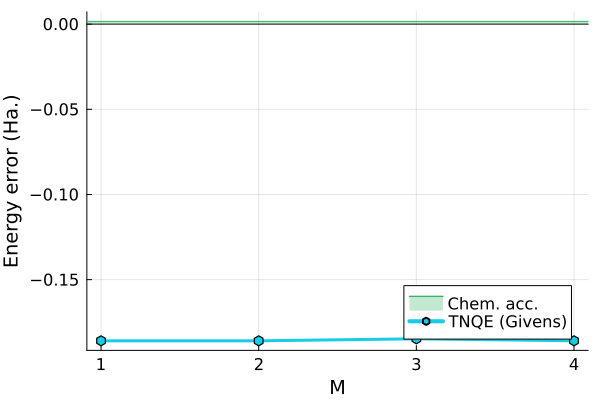

In [14]:
xvals = 1:M_max

#yvals1 = nomps_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
#yvals2 = fswap_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
yvals3 = givens_evec3 .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
println(yvals3)
println("IM FUCKING PRINTING")
plt2 = plot(
    [1.0], 
    [0.0],  
    lw=2.5, 
    primary=false,
    xlabel="M", 
    ylabel="Energy error (Ha.)", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    gridlinewidth=1.0,
    gridalpha=0.1,
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=11
)

hline!([0.0], color=RGB(0.0,0.0,0.0), primary=false)
#plot!(xvals, [0.0016 for x in xvals])
hline!([0.0016], lw=1.0, fillrange = [0.0], fillalpha=0.3, color=RGB(0.2,0.7,0.4), label="Chem. acc.")
#=
plot!(
    xvals, 
    yvals1, 
    markershape=:square,
    markersize=4.2, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.7,0.2),
    label="NOMPS"
)

plot!(
    xvals, 
    yvals2, 
    markershape=:circle, 
    markersize=5.2, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.35,0.35),
    label="TNQE (FSWAP)", 
)
=#
println(yvals3)
plot!(
    xvals, 
    yvals3, 
    markershape=:hexagon, 
    markersize=5.0, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(0.1,0.8,0.9),
    label="TNQE (Givens)"
)

#display(plt2)

#savefig(plt2, pwd()*"/../plots/M_comparison_h4_stretch_0.85A_sto3g_$(Dates.today()).pdf")


In [15]:
println(yvals3)

In [16]:
chi=4

dmrg3_evec = []
dmrg3_pvec = []

dmrg3 = deepcopy(tnqe0)

push!(dmrg3_evec, dmrg3.E[1])
push!(dmrg3_pvec, CountNonZeros(dmrg3.phi_list))

for k=1:12
    
    dmrg3.mparams.mps_maxdim = chi+k
    
    dflt_sweeps=Sweeps(
        20, 
        maxdim=dmrg3.mparams.mps_maxdim, 
        noise=(1e-3,1e-4,1e-6,1e-8,1e-10)
    )
    
    e_dmrg, phi_dmrg = dmrg(dmrg3.H_mpo, dmrg3.phi_list[1], dflt_sweeps)
    
    dmrg3.phi_list[1] = phi_dmrg
    
    push!(dmrg3_evec, e_dmrg)
    push!(dmrg3_pvec, CountNonZeros(dmrg3.phi_list))
    
end

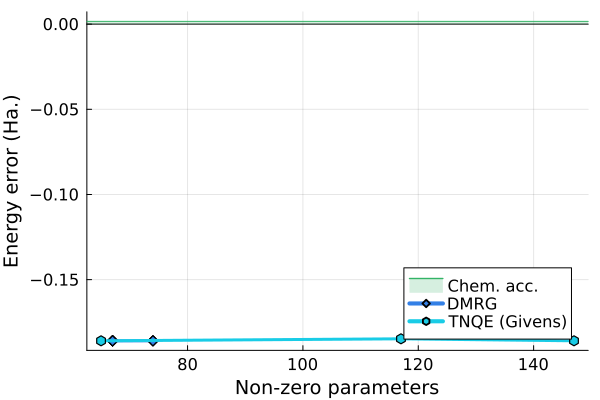

3-element Vector{Any}:
  65
 117
 147

3-element Vector{Float64}:
 -0.18589785636702905
 -0.18472099527283214
 -0.18589218615071257

9-element Vector{Any}:
 74
 67
 67
 67
 74
 74
 67
 67
 67

9-element Vector{Float64}:
 -0.1858982283491355
 -0.18589822834913505
 -0.1858982283491355
 -0.18589822834913594
 -0.18589822834913505
 -0.18589822834913594
 -0.1858982283491355
 -0.18589822834913505
 -0.1858982283491355

In [17]:
using Dates
using Plots

nx1 = [2,4]
nx2 = [5,13]

xvals1 = givens_pvec3[nx1[1]:nx1[2]]
xvals2 = dmrg3_pvec[nx2[1]:nx2[2]]
#xvals3 = fswap_pvec
#xvals4 = nomps_pvec

yvals1 = givens_evec3[nx1[1]:nx1[2]] .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
yvals2 = dmrg3_evec[nx2[1]:nx2[2]] .+ (dmrg3.chem_data.e_nuc - dmrg3.chem_data.e_fci)
#yvals3 = fswap_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
#yvals4 = nomps_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)

plt3 = plot(
    [], 
    [],  
    lw=2.5, 
    primary=false,
    xlabel="Non-zero parameters", 
    ylabel="Energy error (Ha.)", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    gridlinewidth=1.0,
    gridalpha=0.1,
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=11
)

hline!([0.0], color=RGB(0.0,0.0,0.0), primary=false)
#plot!(xvals, [0.0016 for x in xvals])
hline!([0.0016], lw=1.0, fillrange = [0.0], fillalpha=0.2, color=RGB(0.2,0.7,0.4), label="Chem. acc.")

plot!(
    xvals2, 
    yvals2, 
    markershape=:diamond, 
    markersize=5, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(0.2,0.5,0.9),
    label="DMRG"
)

"""
plot!(
    xvals4, 
    yvals4, 
    markershape=:square, 
    markersize=4.0, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.7,0.2),
    label="NOMPS"
)

plot!(
    xvals3, 
    yvals3, 
    markershape=:circle, 
    markersize=5.2, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.35,0.35),
    label="TNQE (FSWAP)"
)

"""

plot!(
    xvals1, 
    yvals1, 
    markershape=:hexagon, 
    markersize=5.0, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(0.1,0.8,0.9),
    label="TNQE (Givens)"
)

display(plt3)
display(xvals1)
display(yvals1)
display(xvals2)
display(yvals2)
#savefig(plt3, pwd()*"/../plots/nnz_comparison_h6_octahedron_1.2A_sto3g_$(Dates.today()).pdf")


In [ ]:
# Quicksave the data:

using Dates

fid = h5open(pwd()*"/../datasets/temp/h4_stretch_0.85A_sto3g_$(Dates.today()).h5", "w")

fid["tnqe_full"] = Float64.(tnqe3_evec_full)
fid["tnqe"] = Float64.(tnqe3_evec)
#fid["nomps_full"] = Float64.(nomps3_evec_full)
#fid["nomps"] = Float64.(nomps3_evec)

close(fid)

HDF5.API.H5Error: HDF5.API.H5Error: Error creating file /Users/brandonschramm/Research/TNQE-Julia-copy/notebooks/../datasets/temp/h2_stretch_1.2A_sto3g_2025-06-24.h5
libhdf5 Stacktrace:
 [1] H5FD__sec2_open: File accessibility/Unable to open file
     unable to open file: name = '/Users/brandonschramm/Research/TNQE-Julia-copy/notebooks/../datasets/temp/h2_stretch_1.2A_sto3g_2025-06-24.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602
  ⋮